In [1]:
from utils import *
from features import *

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from xgboost import XGBRegressor, DMatrix, cv
from xgboost import train as train_xgb

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])

tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
coords_train_df = pd.read_csv('data/geo/train_lat_lon.csv')
coords_train_df.drop(['key', 'tolerance_m'], axis=1, inplace=True)
coords_train_df.index = coords_train_df.id
coords_train_df.drop(['id'], axis=1, inplace=True)
coords_train_df = coords_train_df.sort_index()

coords_test_df = pd.read_csv('data/geo/test_lat_lon.csv')
coords_test_df.drop(['key', 'tolerance_m'], axis=1, inplace=True)
coords_test_df.index = coords_test_df.id
coords_test_df.drop(['id'], axis=1, inplace=True)
coords_test_df = coords_test_df.sort_index()

coords_all_df = pd.concat([coords_train_df, coords_test_df])

In [7]:
train_df['is_train'] = 1
test_df['is_train'] = 0

# coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_all_df['lat']
all_df['longitude'] = coords_all_df['lon']

## 3. Removing outliers

In [8]:
all_df = remove_outliers(all_df)

## 4. Feature engineering

In [9]:
all_df = create_new_features(all_df)

## 5. Removing fake prices

In [10]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

In [11]:
train_df = remove_fake_prices(train_df)

REMOVED: 35


In [12]:
idx_outliers = np.loadtxt('outliers/idx_outliers_full.txt').astype(int)
train_df = train_df.drop(idx_outliers)

## BONUS: Merging `macro.csv` with main

In [13]:
macro_df['timestamp_day'] = macro_df['timestamp'].dt.day
macro_df['timestamp_month'] = macro_df['timestamp'].dt.month
macro_df['timestamp_year'] = macro_df['timestamp'].dt.year
macro_df = macro_df.drop('timestamp', axis=1)

In [14]:
train_macro_df = train_df.merge(macro_df, on=['timestamp_day', 'timestamp_month', 'timestamp_year'], how='left' )
test_macro_df = test_df.merge(macro_df, on=['timestamp_day', 'timestamp_month', 'timestamp_year'], how='left' )

## 6. Modeling

### `product_type == 'Investment'`

In [15]:
train_df_0 = train_df[train_df['product_type'] == 0]
test_df_0 = test_df[test_df['product_type'] == 0]

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])
X_test_0 = test_df_0.drop(['sub_area'], axis=1).copy()

In [16]:
# train_macro_df_0 = train_macro_df[train_macro_df['product_type'] == 0]
# test_macro_df_0 = test_macro_df[test_macro_df['product_type'] == 0]

# X = train_macro_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
# y = np.log1p(train_macro_df_0['price_doc'])
# X_test_0 = test_macro_df_0.drop(['sub_area'], axis=1).copy()

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((13416, 369), (3354, 369))

In [18]:
params = {'objective': 'reg:squarederror',
          # 'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'n_estimators': 10000,
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

model_0 = XGBRegressor(**params)

model_0.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)

[0]	validation_0-rmse:8.40559	validation_1-rmse:8.39902
[1]	validation_0-rmse:7.98623	validation_1-rmse:7.98012
[2]	validation_0-rmse:7.58788	validation_1-rmse:7.58192
[3]	validation_0-rmse:7.20945	validation_1-rmse:7.20379
[4]	validation_0-rmse:6.84994	validation_1-rmse:6.84415
[5]	validation_0-rmse:6.50846	validation_1-rmse:6.50280
[6]	validation_0-rmse:6.18403	validation_1-rmse:6.17866
[7]	validation_0-rmse:5.87585	validation_1-rmse:5.87036
[8]	validation_0-rmse:5.58313	validation_1-rmse:5.57776
[9]	validation_0-rmse:5.30504	validation_1-rmse:5.29993
[10]	validation_0-rmse:5.04087	validation_1-rmse:5.03580
[11]	validation_0-rmse:4.78997	validation_1-rmse:4.78496
[12]	validation_0-rmse:4.55159	validation_1-rmse:4.54665
[13]	validation_0-rmse:4.32520	validation_1-rmse:4.32045
[14]	validation_0-rmse:4.11008	validation_1-rmse:4.10546
[15]	validation_0-rmse:3.90574	validation_1-rmse:3.90123
[16]	validation_0-rmse:3.71166	validation_1-rmse:3.70723
[17]	validation_0-rmse:3.52728	validation

XGBRegressor(base_score=7, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             nthread=-1, num_parallel_tree=1, random_state=42, reg_alpha=1,
             reg_lambda=5, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
y_pred_train = np.abs(model_0.predict(X_train))
y_pred_val = np.abs(model_0.predict(X_val))
print('___________________________________')
print('      RMSLE\n')
print('      TRAIN_0:', np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(y_pred_train))))
print(' VALIDATION_0:', np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_val))))
print('___________________________________')
print('      MAE\n')
print('      TRAIN_0:', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
print(' VALIDATION_0:', mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_val)))

___________________________________
      RMSLE

      TRAIN_0: 0.09823888781102101
 VALIDATION_0: 0.14082009782673952
___________________________________
      MAE

      TRAIN_0: 542280.8126677102
 VALIDATION_0: 826088.2885733453


### `product_type == 'OwnerOccupier'`

In [22]:
train_df_1 = train_df[train_df['product_type'] == 1]
test_df_1 = test_df[test_df['product_type'] == 1]

X = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_1['price_doc'])
X_test_1 = test_df_1.drop(['sub_area'], axis=1).copy()

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((8793, 369), (2199, 369))

In [24]:
params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          # 'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 15,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

model_1 = XGBRegressor(**params)

model_1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)

[0]	validation_0-rmse:8.15090	validation_1-rmse:8.13370
[1]	validation_0-rmse:7.74533	validation_1-rmse:7.72808
[2]	validation_0-rmse:7.36006	validation_1-rmse:7.34277
[3]	validation_0-rmse:6.99410	validation_1-rmse:6.97675
[4]	validation_0-rmse:6.64648	validation_1-rmse:6.62908
[5]	validation_0-rmse:6.31628	validation_1-rmse:6.29883
[6]	validation_0-rmse:6.00262	validation_1-rmse:5.98533
[7]	validation_0-rmse:5.70464	validation_1-rmse:5.68762
[8]	validation_0-rmse:5.42154	validation_1-rmse:5.40432
[9]	validation_0-rmse:5.15258	validation_1-rmse:5.13550
[10]	validation_0-rmse:4.89705	validation_1-rmse:4.87978
[11]	validation_0-rmse:4.65431	validation_1-rmse:4.63685
[12]	validation_0-rmse:4.42367	validation_1-rmse:4.40644
[13]	validation_0-rmse:4.20460	validation_1-rmse:4.18718
[14]	validation_0-rmse:3.99645	validation_1-rmse:3.97940
[15]	validation_0-rmse:3.79873	validation_1-rmse:3.78232
[16]	validation_0-rmse:3.61090	validation_1-rmse:3.59452
[17]	validation_0-rmse:3.43248	validation

XGBRegressor(base_score=7, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             nthread=-1, num_parallel_tree=1, random_state=42, reg_alpha=1,
             reg_lambda=15, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
y_pred_train = np.abs(model_1.predict(X_train))
y_pred_val = np.abs(model_1.predict(X_val))
print('___________________________________')
print('      RMSLE\n')
print('      TRAIN_1:', np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(y_pred_train))))
print(' VALIDATION_1:', np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_val))))
print('___________________________________')
print('      MAE\n')
print('      TRAIN_1:', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
print(' VALIDATION_1:', mean_absolute_error(np.expm1(y_val), np.expm1(y_pred_val)))

___________________________________
      RMSLE

      TRAIN_1: 0.050964123254926906
 VALIDATION_1: 0.08513745387712202
___________________________________
      MAE

      TRAIN_1: 241723.72947230763
 VALIDATION_1: 379582.21327876317


In [30]:
test_df_nan = test_df[test_df['product_type'].isna()]
X_test_nan = test_df_nan.drop(['sub_area'], axis=1).copy()

In [31]:
submission = pd.read_csv('data/submits/sample_submission.csv', index_col='id')
pred_0 = np.expm1(model_0.predict(X_test_0))
pred_1 = np.expm1(model_1.predict(X_test_1))
pred_nan = np.expm1(model_1.predict(X_test_nan))

if len(pred_0[pred_0 < 0]) or len(pred_1[pred_1 < 0]) or len(pred_nan[pred_nan < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')

In [45]:
submission.loc[X_test_0.index, 'price_doc'] = 0.87*pred_0 # 0.87
submission.loc[X_test_1.index, 'price_doc'] = 0.91*pred_1
submission.loc[X_test_nan.index, 'price_doc'] = pred_nan # 0.95
submission.to_csv('data/submits/submission.csv', index='id')

In [46]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "data/submits/submission.csv" -m "XGBRegressor new features"

100%|████████████████████████████████████████| 121k/121k [00:03<00:00, 38.1kB/s]
Successfully submitted to Sberbank Russian Housing Market

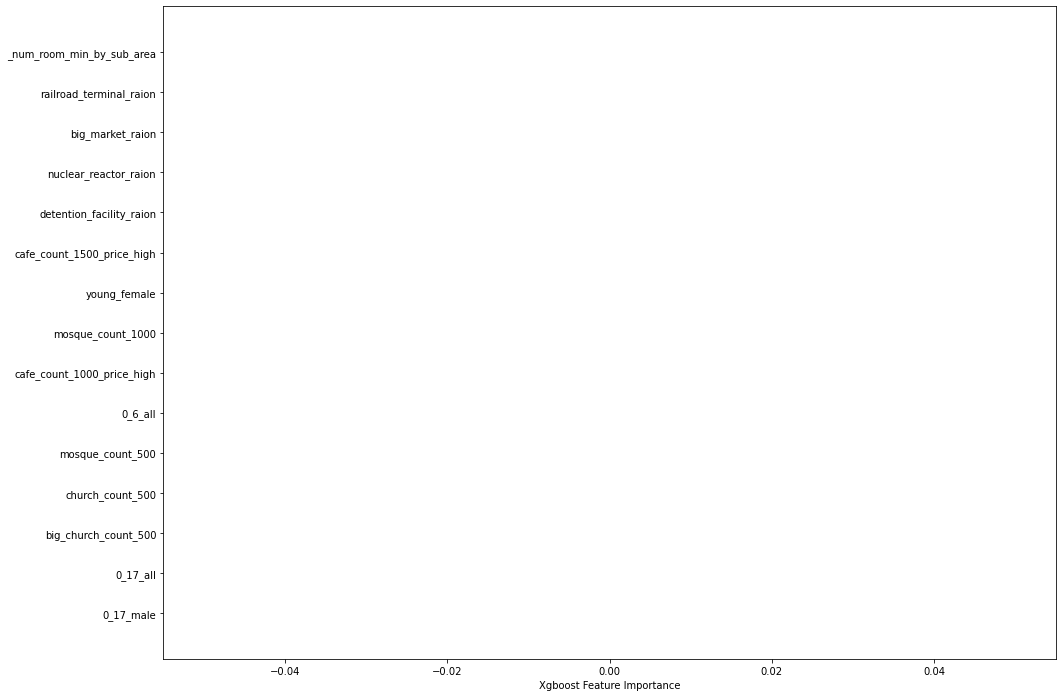

In [58]:
plt.figure(figsize=(16, 12))
sorted_idx = model_0.feature_importances_.argsort()[::-1]
plt.barh(X.columns[sorted_idx[-15:]], model_0.feature_importances_[sorted_idx[-15:]])
plt.xlabel("Xgboost Feature Importance");